In [1]:
"""
construct a motoman scene, and test the collision methods in Drake
"""

# reference: authoring_multibody_simulation.ipynb

# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import FindResourceOrThrow, temp_directory
from pydrake.geometry import (
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Role,
    StartMeshcat,
    SceneGraph
)
from pydrake.math import RigidTransform, RollPitchYaw, RotationMatrix
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph, MultibodyPlant
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder, Context, Diagram
from pydrake.visualization import ModelVisualizer
import json
from pydrake.geometry import Box, HalfSpace
from pydrake.multibody.tree import SpatialInertia
from pydrake.multibody.plant import CoulombFriction
import transformations as tf
from pydrake.systems.drawing import plot_graphviz, plot_system_graphviz

motoman_model_file = '/home/yinglong/Documents/research/task_motion_planning/infrastructure/motoman_ws/src/pracsys-motoman/motoman/motoman_config/updated_obj_urdf/motoman_dual.urdf'


In [2]:
# Start the visualizer. The cell will output an HTTP link after the execution.
# Click the link and a MeshCat tab should appear in your browser.
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
# load the scene file from json, and construct the workspace

def load_scene_workspace(plant: MultibodyPlant):
    scene_f = 'scene.json'
    f = open(scene_f, 'r')
    scene_dict = json.load(f)
    base_pos = scene_dict['workspace']['pos']
    components = scene_dict['workspace']['components']
    spatial_inertia = SpatialInertia()
    new_model_instance = plant.AddModelInstance("workspace_model_instance")
    body = plant.AddRigidBody(name="workspace", model_instance=new_model_instance, M_BBo_B=spatial_inertia)  # this is the body representing the environment
        
    for component_name, component in components.items():
        shape = component['shape']
        shape = np.array(shape)
        # pos = np.array(component['pose']['pos'])
        component['pose']['pos'] = np.array(component['pose']['pos']) + np.array(base_pos)
        pos = np.array(component['pose']['pos'])
        ori = component['pose']['ori']  # x y z w
        alpha = 1.0
        quat = tf.quaternion_matrix([ori[3],ori[0],ori[1],ori[2]])
        R = RotationMatrix(quat[:3,:3])
        body_X_BG = RigidTransform(R=R, p=pos)
        body_friction = CoulombFriction(static_friction=0.6,
                                        dynamic_friction=0.5)
        # create a plant body
        col_shape = Box(width=shape[0], depth=shape[1], height=shape[2])
        vid = plant.RegisterVisualGeometry(body=body, X_BG=body_X_BG, shape=col_shape, name=component_name+'_visual',
                                     diffuse_color=[1., 0.64, 0.0, 1.0])
        cid = plant.RegisterCollisionGeometry(body=body, X_BG=body_X_BG, shape=col_shape, name=component_name+'_collision',
                                        coulomb_friction=body_friction)

    return body, base_pos

In [4]:
def create_scene(sim_time_step=0.0001):
    # Clean up the Meshcat instance.
    meshcat.Delete()
    meshcat.DeleteAddedControls()

    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(
        builder, time_step=sim_time_step)
    parser = Parser(plant)

    # Loading models.

    # Weld the table to the world so that it's fixed during the simulation.
    
    parser.package_map().PopulateFromFolder('/home/yinglong/Documents/research/task_motion_planning/infrastructure/motoman_ws/src/pracsys-motoman/motoman/motoman_config')
    parser.AddModels(motoman_model_file)

    table_frame = plant.GetFrameByName("base")
    plant.WeldFrames(plant.world_frame(), table_frame)

    # add workspace
    workspace_body, workspace_pos = load_scene_workspace(plant)
    X_WorldB = RigidTransform(p=workspace_pos)

    plant.WeldFrames(plant.world_frame(), workspace_body.body_frame(), X_WorldB)

    
#     AddGround(plant)

    # Finalize the plant after loading the scene.
    plant.Finalize()
    
    # We use the default context to calculate the transformation of the table
    # in world frame but this is NOT the context the Diagram consumes.
    plant_context = plant.CreateDefaultContext()

    # Set the initial pose for the free bodies, i.e., the custom box and the
    # cracker box.
    body = plant.GetBodyByName("workspace")

    
    # get the workspace pose    
#     X_WorldB = RigidTransform(p=workspace_pos)

#     plant.SetFreeBodyPose(plant_context, body, X_WorldB)

    # Add visualizer to visualize the geometries.
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, scene_graph, meshcat,
        MeshcatVisualizerParams(role=Role.kPerception, prefix="visual"))

    diagram = builder.Build()
    return diagram, visualizer, plant, scene_graph

In [5]:
def initialize_simulation(diagram):
    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(1.)
    return simulator

def run_simulation(sim_time_step):
    diagram, visualizer, _, _ = create_scene(sim_time_step)
    simulator = initialize_simulation(diagram)
    visualizer.StartRecording()
    simulator.AdvanceTo(1.0)
    visualizer.PublishRecording()

# Run the simulation with a small time step. Try gradually increasing it!
# run_simulation(sim_time_step=0.0001)

In [6]:
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'webagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [7]:
# This is non-interactive: it shows static plots inline
# %matplotlib inline

# This is interactive: it shows dynamic plots in the notebook
%matplotlib notebook

# This is interactive: it shows dynamic plots in separate GUI windows
# %matplotlib tk

In [8]:
# visualize the topology graph
# https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/systems/drawing_graphviz_example.py
import matplotlib.pyplot as plt

# plt.figure(figsize=(11, 8.5), dpi=300)
# plot_graphviz(plant.GetTopologyGraphvizString())
# plt.show()

In [9]:
# plt.figure(figsize=(11, 8.5), dpi=300)
# plot_system_graphviz(diagram, max_depth=2)

In [10]:
def get_joints(plant: MultibodyPlant, context: Context, joint_names):
    joint_dict = {}
    for name in joint_names:
        joint = plant.GetJointByName(name)
        joint_dict[name] = joint
    return joint_dict

def get_joint_values(plant: MultibodyPlant, context: Context, joint_names):
    joint_val_dict = {}
    for name in joint_names:
        joint = plant.GetJointByName(name)
        type_name = joint.type_name()
        joint_val_dict[name] = joint.GetOnePosition(context)
    return joint_val_dict

def set_joint_values(plant: MultibodyPlant, context: Context, joint_val_dict):
    # this assumes that all joints are revolute joints
    for name, val in joint_val_dict.items():
        joint = plant.GetJointByName(name)
        joint.set_angle(context, val)

def set_joint_values_list(plant: MultibodyPlant, context: Context, joint_vals):
    plant.SetPositions(context, joint_vals)

In [11]:
# https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/multibody/test/plant_test.py#L2402

def test_collision_test(sim_time_step=0.0001):
    diagram, visualizer, plant, scene_graph = create_scene(sim_time_step)
    
#     plt.figure(figsize=(11, 8.5), dpi=300)
#     plot_graphviz(plant.GetTopologyGraphvizString());
#     plt.savefig('drawing_graphviz_example.png')

#     plt.show()

#     plt.figure(figsize=(11, 8.5), dpi=300)
#     plot_system_graphviz(diagram, max_depth=2);
#     plt.savefig('drawing_system_graphviz_example.png')

#     plt.show()
    context = diagram.CreateDefaultContext()
    sg_context = diagram.GetMutableSubsystemContext(scene_graph, context)
    plant_context = diagram.GetMutableSubsystemContext(plant, context)
        
    # * set the robot configuration to a certain state
    # print out the mutable configurations
#     position = plant.GetMutablePositions(context)
    position = plant.GetMutablePositions(plant_context)

    print('joint angle: ', position)
    
    joint_names = ['torso_joint_b1', 'arm_right_joint_1_s', 'arm_right_joint_2_l']
    get_joint_values(plant, plant_context, joint_names)
    joint_val_dict = {'torso_joint_b1': 0.1}
    set_joint_values(plant, plant_context, joint_val_dict)
    print('after setting joint values: ')
    print('joint angle: ', position)
    get_joint_values(plant, plant_context, joint_names)
    
    # * check collision by getting the output query of scene graph
    query_object = scene_graph.get_query_output_port().Eval(sg_context)
    # Implicitly require that this should be size 1.
    point_pair = query_object.ComputePointPairPenetration()
    signed_distance_pair = query_object.\
        ComputeSignedDistancePairwiseClosestPoints()
    signed_distance_to_point = query_object.\
        ComputeSignedDistanceToPoint(p_WQ=np.ones(3))
#     self.assertEqual(len(signed_distance_to_point), 2)
#     self.assertIsInstance(signed_distance_to_point[0],
#                           SignedDistanceToPoint_[T])
#     self.assertIsInstance(signed_distance_to_point[1],
#                           SignedDistanceToPoint_[T])
    print('point_pair: ')
    print(point_pair)

In [34]:
# https://github.com/RobotLocomotion/drake/blob/master/bindings/pydrake/multibody/test/plant_test.py#L2402
def test_collision(joint_vals,
                   plant: MultibodyPlant, scene_graph: SceneGraph, diagram: Diagram,
                   sim_time_step=0.0001):
    """
    given a joint value list (within the joint range), check collision
    """
    context = diagram.CreateDefaultContext()
    sg_context = diagram.GetMutableSubsystemContext(scene_graph, context)
    plant_context = diagram.GetMutableSubsystemContext(plant, context)

    # * set the robot configuration to a certain state
    # print out the mutable configurations
    set_joint_values_list(plant, plant_context, joint_vals)
    
    # * check collision by getting the output query of scene graph
    query_object = scene_graph.get_query_output_port().Eval(sg_context)
    # Implicitly require that this should be size 1.
    point_pair = query_object.ComputePointPairPenetration()
    signed_distance_pair = query_object.\
        ComputeSignedDistancePairwiseClosestPoints()
    signed_distance_to_point = query_object.\
        ComputeSignedDistanceToPoint(p_WQ=np.ones(3))
#     self.assertEqual(len(signed_distance_to_point), 2)
#     self.assertIsInstance(signed_distance_to_point[0],
#                           SignedDistanceToPoint_[T])
#     self.assertIsInstance(signed_distance_to_point[1],
#                           SignedDistanceToPoint_[T])
#     print('point_pair: ')
#     print(point_pair)
    return len(point_pair)>0, context

In [69]:
import numpy as np

diagram, visualizer, plant, scene_graph = create_scene(sim_time_step=0.0001)

# * generate a random joint angle within the range
ll = plant.GetPositionLowerLimits()
ul = plant.GetPositionUpperLimits()
ll = np.array(ll)
ul = np.array(ul)
rand_joint = np.random.uniform(ll, ul)
print('random joint: ', rand_joint)

col, context = test_collision(rand_joint, plant, scene_graph, diagram, sim_time_step=0.0001)


random joint:  [ 0.23616668  1.81365121 -1.81333937  1.5268512  -1.35930621  0.72125395
 -1.63019337 -2.17529955 -0.52778678 -0.1499602  -1.84403307 -1.26324392
  2.42665281 -1.24630902  0.68371223]


In [70]:
simulator = Simulator(diagram, context)
# reset_context
simulator.Initialize()
simulator.set_target_realtime_rate(1.)

In [71]:
visualizer.StartRecording()
simulator.AdvanceTo(0.0)
visualizer.PublishRecording()

In [35]:
import time
# * batched testing for the collision checker
diagram, visualizer, plant, scene_graph = create_scene(sim_time_step=0.0001)

# * generate a random joint angle within the range
ll = plant.GetPositionLowerLimits()
ul = plant.GetPositionUpperLimits()
ll = np.array(ll)
ul = np.array(ul)

num_samples = 1000
rand_joints = np.random.uniform(ll, ul, size=[num_samples] + list(ll.shape))

total_times = []
collisions = []
for i in range(num_samples):
#     print('random joint: ', rand_joint)
    start_time_i = time.time()
    col, context = test_collision(rand_joints[i], plant, scene_graph, diagram, sim_time_step=0.0001)
    duration_i = time.time() - start_time_i
    total_times.append(duration_i)
    collisions.append(col)

print('done')

done


In [40]:
total_times = np.array(total_times)
collisions = np.array(collisions).astype(bool)

<IPython.core.display.Javascript object>


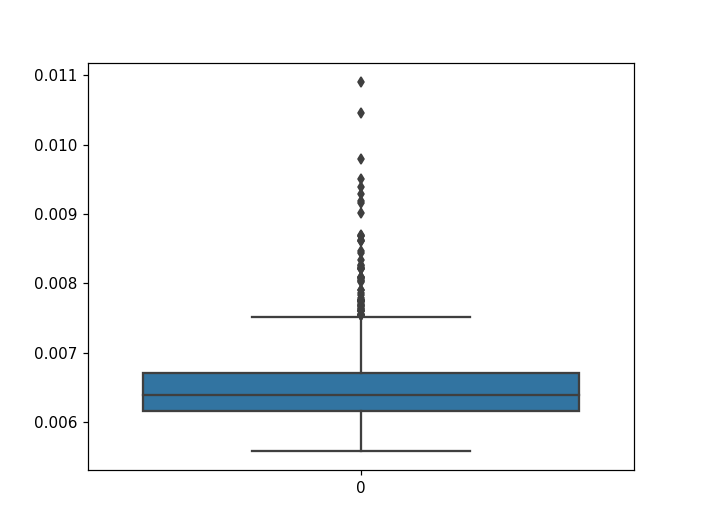

In [45]:
# * draw a statistics of the total time
import seaborn as sb
plt.figure()
sb.boxplot(total_times)
plt.savefig('total_timing_boxplot.png')

collision timing


<IPython.core.display.Javascript object>


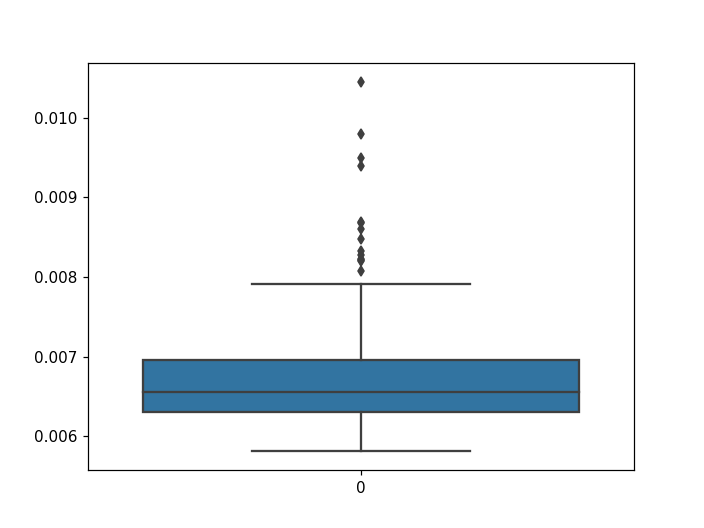

In [46]:
print('collision timing')
plt.figure()
sb.boxplot(total_times[collisions])
plt.savefig('collision_timing_boxplot.png')

non-collision timing


<IPython.core.display.Javascript object>


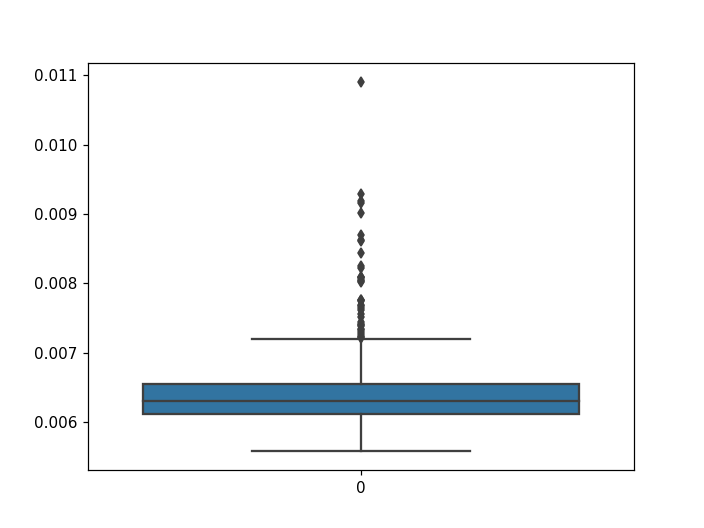

In [47]:
print('non-collision timing')
plt.figure()
sb.boxplot(total_times[~collisions])
plt.savefig('non_collision_timing_boxplot.png')

In [44]:
# number of collisions
print('number of collisions: ', collisions.astype(int).sum() / len(collisions))

number of collisions:  0.353
